# Pet Breed Classification

> Multi-class classification using FastAI
- order: 2
- image: thumbnail.png
- callout-appearance: simple
- toc-depth: 2
- date: 2023-03-09

Credits: *Practical Deep Learning for Coders* [book](https://course.fast.ai/Resources/book.html) by Jeremy Howard and Sylvain Gugger.

## Data
Let's first download the data:

In [ ]:
#| hide
#| hide_output
!pip install nbdev

Running on Quadro P5000 16GB.

In [ ]:
from fastai.vision.all import *
device = 'gpu'

## Data Preparation

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_56.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_61.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_66.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_55.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_68.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_153.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_57.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_100.jpg')...]

In [ ]:
fname = (path/'images').ls()[0]
fname

Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_56.jpg')

If we want to extract the breed itself from the name we can use regex: 

In [ ]:
m = re.match(r"(.+)_\d+.jpg", fname.name)
breed = m.group(1)
breed

'american_bulldog'

`item_tfms` is applied to all images. Here it resizes images to some large value first.

`batch_tfms` is applied only on mini-batches (on GPU if set as device). Here it crops and scales images. Note that validation set does not get augmented, only gets resized.

In [ ]:
pets = DataBlock(blocks= (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [ ]:
pets.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pug_130.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x225
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pug_130.jpg
    applying partial gives
      pug
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(29)

Final sample: (PILImage mode=RGB size=300x225, TensorCategory(29))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize 

In [ ]:
dls = pets.dataloaders(path/"images")

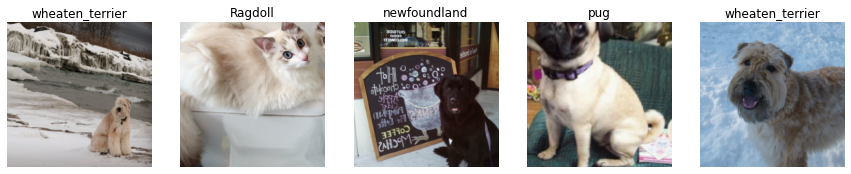

In [ ]:
dls.show_batch(nrows=1, ncols=5)

Let's create learner, and define dataloaders, model, and metrics (optimizer and loss are deducted automatically).

## Training

In [ ]:
learner = vision_learner(dls, resnet34, metrics=error_rate)
learner.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.505711,0.344845,0.109608,00:35
1,0.342231,0.221326,0.073072,00:34


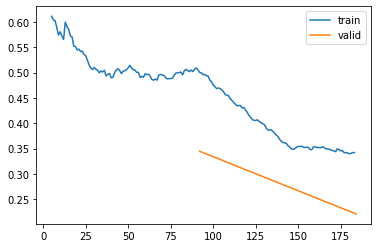

In [ ]:
learner.recorder.plot_loss()

We can definitely train more using `fine_tune` but the error rate seem small so let's take a look at some predictions:

In [ ]:
x, y = dls.one_batch()

In [ ]:
y

TensorCategory([ 1, 13, 30, 25, 28, 32, 24,  1, 17, 28, 21, 16, 11,  3, 36, 25,
                34, 30, 13, 21, 15, 24,  0,  9,  0, 27, 31,  2, 18, 25,  4, 14,
                27, 35, 19, 33, 21, 34,  2,  4, 31, 30, 19,  0, 36, 30, 31, 35,
                14, 12, 18,  7,  8, 31, 15, 20, 16, 13, 29,  1, 16,  9, 32, 10],
               device='cuda:0')

In [ ]:
preds, class_preds = learner.get_preds(dl=[(x, y)])

In [ ]:
print(preds.shape)
print(preds)
class_preds

torch.Size([64, 37])
TensorBase([[1.2718e-02, 7.3877e-01, 1.2443e-05,  ..., 1.4487e-05,
             2.1402e-05, 2.4068e-06],
            [2.1086e-04, 3.4171e-05, 2.3038e-05,  ..., 1.0070e-01,
             3.7866e-04, 1.8155e-05],
            [2.2906e-07, 6.6254e-08, 2.3534e-07,  ..., 1.0171e-07,
             2.4211e-07, 3.6889e-07],
            ...,
            [2.1525e-06, 7.6821e-08, 2.3279e-08,  ..., 1.8256e-07,
             1.4531e-08, 5.4367e-10],
            [4.5686e-10, 1.6017e-08, 2.5129e-09,  ..., 7.3533e-09,
             1.6970e-05, 1.6900e-07],
            [1.7999e-08, 7.1642e-11, 2.4699e-06,  ..., 2.8352e-10,
             1.9007e-09, 1.4708e-09]])


tensor([ 1, 13, 30, 25, 28, 32, 24,  1, 17, 28, 21, 16, 11,  3, 36, 25, 34, 30,
        13, 21, 15, 24,  0,  9,  0, 27, 31,  2, 18, 25,  4, 14, 27, 35, 19, 33,
        21, 34,  2,  4, 31, 30, 19,  0, 36, 30, 31, 35, 14, 12, 18,  7,  8, 31,
        15, 20, 16, 13, 29,  1, 16,  9, 32, 10])

There are 64 samples in a batch, each having a probability of a certain class. The `class_preds` is just argmax of preds:

In [ ]:
preds.argmax(dim=1)

TensorBase([ 1, 13, 30, 25, 28, 32, 24,  1, 17, 28, 21, 16, 11,  3, 36, 25, 34,
            30, 13, 21, 15, 24,  0,  9,  1, 27, 31,  2, 18, 25,  4, 14, 27, 35,
            19, 33, 21, 34,  2,  4, 31, 30, 19,  0, 36, 30, 31, 35, 14, 12, 19,
             7,  8, 31, 15, 20, 16, 13, 29,  1, 16,  9, 32, 10])

So learner deducted this is a multi-category problem, and have decided on `nn.CrossEntropyLoss` (which is combo of `nn.LogSoftmax` and `nn.NLLLoss`). What's important is to apply `nn.CrossEntropyLoss` on logits, not on probabilites, so our model should not have softmax layer at the end.

`Softmax` is a multi-category equivalent of sigmoid. We use it any time when we want to convert logits into probabilites, and we want them to sum up to 1.

`Log` is important because it's easier to optimize, since difference between, say, 0.99 and 0.999 is 10 fold, not negligible.

## Model interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

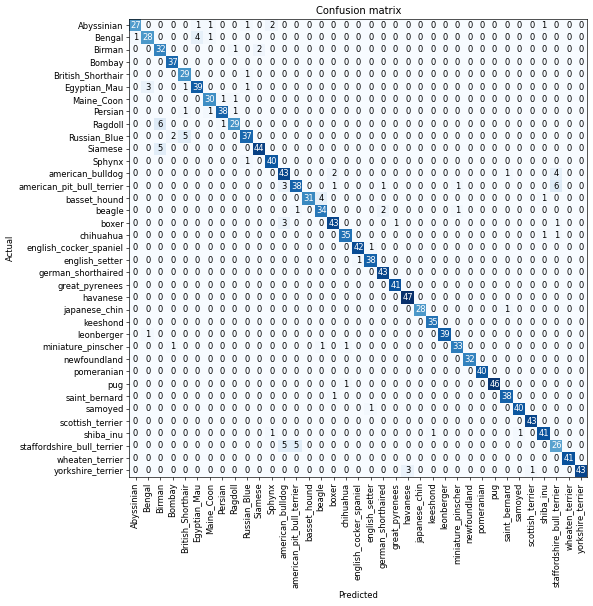

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [ ]:
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('Siamese', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('basset_hound', 'beagle', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('boxer', 'american_bulldog', 3),
 ('yorkshire_terrier', 'havanese', 3)]

## Learning rate finder

Let's train with some large learning rate (run it for 1 epoch every time with `base_lr`):

In [ ]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.900633,1.380544,0.409337,00:25


In [ ]:
learner.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.599579,1.268538,0.391746,00:26


In [ ]:
learner.fine_tune(1, base_lr=0.2)

epoch,train_loss,valid_loss,error_rate,time
0,5.310261,4.817607,0.616373,00:25


So clearly we are diverging. We can use learning rate finder to deduct the good learning rate:

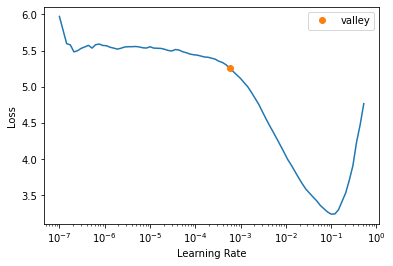

In [ ]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
lr_min = learner.lr_find()

In [ ]:
print(f'{lr_min.valley:.2e}')

5.75e-04


## Transfer learning

The idea here is the same as before, we replace the last layer, freeze all but that last layer, then train. A version of this is done with the following:

In [ ]:
learner.fine_tune??

Signature:
learner.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /usr/local/lib/python3.9/dist-packages/fastai/callback/schedule.py
Type:      method


Where `learner.freeze` will freeze up to a last layer: 

In [ ]:
learner.freeze??

Signature: learner.freeze()
Docstring: Freeze up to last parameter group
Source:   
@patch
def freeze(self:Learner): self.freeze_to(-1)
File:      /usr/local/lib/python3.9/dist-packages/fastai/learner.py
Type:      method


`learner.fit_one_cycle` trains whatever is unfrozen with some scheduler (will study it later):

In [ ]:
learner.fit_one_cycle??

Signature:
learner.fit_one_cycle(
    n_epoch,
    lr_max=None,
    div=25.0,
    div_final=100000.0,
    pct_start=0.25,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False, start_epoch=0):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
File:      /usr/local/lib/python3.9/dist-packages/fastai/callback/schedule.py
Type:      me

In [ ]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fit_one_cycle(3, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,2.346319,0.579111,0.176590,00:22
1,1.001505,0.389489,0.131258,00:21
2,0.690984,0.360593,0.121786,00:22


In [ ]:
learner.unfreeze()

SuggestedLRs(valley=0.0002290867705596611)

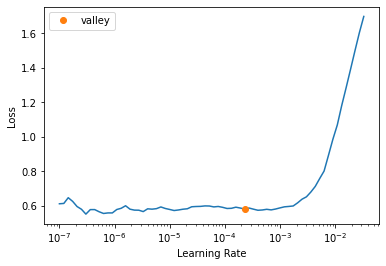

In [ ]:
learner.lr_find()

Loss is flat for small LRs because we already trained for 3 epochs.

# Discriminative learning rates

Let's try to train with different learning rates for different layers. We can do it by passing a list (via `slice`) of learning rates to `fit_one_cycle` so early layers will have smaller learning rate (these layers learn about major edges) vs later layers (which learn about more specific details faster):


In [ ]:
learner = vision_learner(dls, resnet34, metrics=error_rate)
learner.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.165250,0.328640,0.099459,00:28
1,0.543935,0.273579,0.094046,00:28
2,0.338364,0.218583,0.070365,00:28


In [ ]:
learner.unfreeze()
learner.fit_one_cycle(3, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.267663,0.217494,0.071719,00:34
1,0.240454,0.205031,0.072395,00:34
2,0.214869,0.204856,0.069012,00:35


So validation loss got better overall, error_rate flattened.

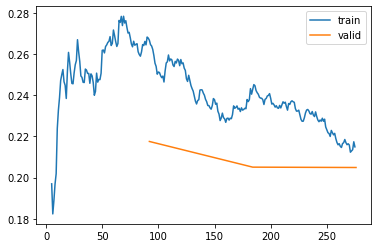

In [ ]:
learner.recorder.plot_loss()

# Half-precision training

We'll speed up training by using half-precision training. We can do it by passing `to_fp16':

In [ ]:
from fastai.callback.fp16 import *
learner = vision_learner(dls, resnet18, metrics=error_rate).to_fp16()
learner.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,0.374304,0.270750,0.094046,00:27
1,0.378627,0.319606,0.105548,00:27
2,0.292685,0.285336,0.093369,00:27
3,0.203631,0.263839,0.088633,00:27
4,0.145154,0.263045,0.087280,00:27
5,0.119077,0.252303,0.084574,00:27


This was `resnet18`, let's try `resnet50`:

In [ ]:
from fastai.callback.fp16 import *
learner = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learner.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,0.267938,0.229196,0.073072,00:58
1,0.314602,0.392396,0.100812,00:58
2,0.252791,0.325749,0.098106,00:58
3,0.168045,0.223274,0.065629,00:59
4,0.093663,0.190344,0.056834,00:58
5,0.059073,0.192047,0.056834,00:58


Clearly an improvement!